In [1]:
import dataset_utils

import albumentations as albu
from collections import defaultdict
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import time
import timm
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchinfo import summary
import torchmetrics
from torchviz import make_dot


C:\Users\n.litvinenko\PycharmProjects\Procedia\venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
print(f'timm.list_models() :\n{timm.list_models()}')

timm.list_models() :
['bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_small', 'coat_tiny', 'coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_

In [2]:

DATASET_PATH = os.path.join('D:\\','Capillaroscopy')
CAPILLAROSCOPY_PATH = os.path.join(DATASET_PATH, 'FullDataset_nf_gc_1000x1000x3')
MASKS_PATH = os.path.join(DATASET_PATH, 'FullDataset_nf_gc_1000x1000x3_Masks')
DF_PATH = os.path.join(CAPILLAROSCOPY_PATH, 'Responses.xlsx')
MODELS_DIR = os.path.join(os.getcwd(), 'models')
BEST_MODEL = 'best_model.pth'
TRAIN_VAL_LOGS = 'train_val_logs.txt'

GENDER = 'Gender'
SEX = 'Sex'
IS_SMOKING = 'is_smoking'
BLOOD_TYPE = 'BloodType'
RH_POS = 'BloodType_RHpos'
RH_NEG = 'BloodType_RHneg'
RH = 'Rh_factor'

AGE = 'Age'
HCT = 'HCT'
HGB = 'HGB'
RBC = 'RBC'
MCV = 'MCV'
RDW = 'RDW'
MCH = 'MCH'
MCHC = 'MCHC'
PLT = 'PLT'
WBC = 'WBC'
NEUT_P = 'NEUT%'
LYMP_P = 'LYMP%'
MONO_P = 'MONO%'
EOS_P = 'EOS%'
BASO_P = 'BASO%'
NEUT = 'NEUT'
LYMP = 'LYMP'
MONO = 'MONO'
EOS = 'EOS'
BASO = 'BASO'
ESR = 'ESR'

MALE = 'Male'
FEMALE = 'Female'

NF_DIR_NAME = 'local_path_Nailfold_gc'
TRAIN_VAL_TEST = 'is_val_or_test_set'
FOLD_NF_GC = 'fold_nf_gc'
IMAGE_RATING = 'Image_rating'

TOP_LEFT_REGION = 'top left region'
CENTRAL_LEFT_REGION = 'central left region'
BOTTOM_LEFT_REGION = 'bottom left region'

TOP_CENTRAL_REGION = 'top central region'
CENTRAL_REGION = 'central region'
BOTTOM_CENTRAL_REGION = 'bottom central region'

TOP_RIGHT_REGION = 'top right region'
CENTRAL_RIGHT_REGION = 'central right region'
BOTTOM_RIGHT_REGION = 'bottom right region'

REGIONS = [TOP_LEFT_REGION, CENTRAL_LEFT_REGION, BOTTOM_LEFT_REGION, TOP_CENTRAL_REGION, CENTRAL_REGION, BOTTOM_CENTRAL_REGION, TOP_RIGHT_REGION, CENTRAL_RIGHT_REGION, BOTTOM_RIGHT_REGION]

CAT_LABELS = (GENDER, IS_SMOKING, BLOOD_TYPE, RH)
NUM_LABELS = (AGE, HCT, HGB, RBC, MCV, RDW, MCH, MCHC, PLT, WBC, NEUT_P, LYMP_P, MONO_P, EOS_P, BASO_P, NEUT, LYMP, MONO, EOS, BASO, ESR)
GT_MASKS_NUMBERS = (0, 499)

NAIL_ZONE = 'Nail zone;'
UNCERTAIN_ZONE = 'Uncertain zone;'
TOTAL_RANK_IS = 'total rank is'

UNCERTAIN = 'morphology is uncertain'
UNKNOWN = 'morphology is the unknown' # !!!
HAIRPIN = 'morphology is the hairpin'
CROSSING = 'morphology is the crossing'

NAIL_CAT = 0
UNCERTAIN_CAT = 1
HAIRPIN_CAT = 2
CROSSING_CAT = 3

REGIONS_DIM = (3, 3)

CLASSES = (NAIL_CAT, UNCERTAIN_CAT, HAIRPIN_CAT, CROSSING_CAT)

TRAIN_VAL_TEST_RATIO = (8, 2, 1) # (3, 1, 1) # (14, 3, 3)

BATCH_SIZE = 8 # 16 # 32 # 4 # 64
LR1 = 1e-4 # 1e-3
NUM_OF_EPOCHS = 250 # 300 # 200 # 100 # 160 # 1

REGION_MODEL_RESIZE = (384, 384) # (224, 224)

DEVICE = 'cuda:0'
ACC = 'accuracy'
DICE = 'dice'
LOSS = 'CrossEntropyLoss' # torch.nn.CrossEntropyLoss()
SUBLOSS1 = 'dice_loss' # 'ce_loss''
SUBLOSS2 = 'bce_loss' # 'pt'

PRETRAINED = True

In [3]:
dataset_utils.test_cuda()
n_cpu = os.cpu_count()
print(f'n_cpu: {n_cpu}')

torch.cuda.is_available(): True
torch.cuda.device_count(): 1
torch.cuda.current_device(): 0
torch.cuda.get_device_name(): NVIDIA GeForce RTX 3090
torch.cuda.get_device_properties(): _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24575MB, multi_processor_count=82)
torch.cuda.get_device_capability(): (8, 6)
n_cpu: 20


In [4]:

df = pd.read_excel(DF_PATH, engine='openpyxl')
df = df.dropna(how='all')
df = df.iloc[(df[NF_DIR_NAME] != 0).to_numpy(), :]
df_cols = (NF_DIR_NAME, TOP_LEFT_REGION, CENTRAL_LEFT_REGION, BOTTOM_LEFT_REGION, TOP_CENTRAL_REGION, CENTRAL_REGION, BOTTOM_CENTRAL_REGION, TOP_RIGHT_REGION, CENTRAL_RIGHT_REGION, BOTTOM_RIGHT_REGION)
df = df.filter(items=df_cols)
pd.set_option('display.max_rows', len(df))


In [5]:

column_headers = list(df.columns.values)
print("The Column Header :", column_headers)


The Column Header : ['local_path_Nailfold_gc', 'top left region', 'central left region', 'bottom left region', 'top central region', 'central region', 'bottom central region', 'top right region', 'central right region', 'bottom right region']


In [6]:
# Convert labels to integers

"""
df[TOP_LEFT_REGION].mask(df[TOP_LEFT_REGION].str.contains(NAIL_ZONE, case=False) | df[TOP_LEFT_REGION].str.contains(UNCERTAIN_ZONE, case=False), NAIL_CAT, inplace=True)
df[CENTRAL_LEFT_REGION].mask(df[CENTRAL_LEFT_REGION].str.contains(NAIL_ZONE, case=False) | df[CENTRAL_LEFT_REGION].str.contains(UNCERTAIN_ZONE, case=False), NAIL_CAT, inplace=True)
df[BOTTOM_LEFT_REGION].mask(df[BOTTOM_LEFT_REGION].str.contains(NAIL_ZONE, case=False) | df[BOTTOM_LEFT_REGION].str.contains(UNCERTAIN_ZONE, case=False), NAIL_CAT, inplace=True)
df[TOP_CENTRAL_REGION].mask(df[TOP_CENTRAL_REGION].str.contains(NAIL_ZONE, case=False) | df[TOP_CENTRAL_REGION].str.contains(UNCERTAIN_ZONE, case=False), NAIL_CAT, inplace=True)
df[CENTRAL_REGION].mask(df[CENTRAL_REGION].str.contains(NAIL_ZONE, case=False) | df[CENTRAL_REGION].str.contains(UNCERTAIN_ZONE, case=False), NAIL_CAT, inplace=True)
df[BOTTOM_CENTRAL_REGION].mask(df[BOTTOM_CENTRAL_REGION].str.contains(NAIL_ZONE, case=False) | df[BOTTOM_CENTRAL_REGION].str.contains(UNCERTAIN_ZONE, case=False), NAIL_CAT, inplace=True)
df[TOP_RIGHT_REGION].mask(df[TOP_RIGHT_REGION].str.contains(NAIL_ZONE, case=False) | df[TOP_RIGHT_REGION].str.contains(UNCERTAIN_ZONE, case=False), NAIL_CAT, inplace=True)
df[CENTRAL_RIGHT_REGION].mask(df[CENTRAL_RIGHT_REGION].str.contains(NAIL_ZONE, case=False) | df[CENTRAL_RIGHT_REGION].str.contains(UNCERTAIN_ZONE, case=False), NAIL_CAT, inplace=True)
df[BOTTOM_RIGHT_REGION].mask(df[BOTTOM_RIGHT_REGION].str.contains(NAIL_ZONE, case=False) | df[BOTTOM_RIGHT_REGION].str.contains(UNCERTAIN_ZONE, case=False), NAIL_CAT, inplace=True)

df[TOP_LEFT_REGION].mask(df[TOP_LEFT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[TOP_LEFT_REGION].str.contains(UNCERTAIN, case=False), UNCERTAIN_CAT, inplace=True)
df[CENTRAL_LEFT_REGION].mask(df[CENTRAL_LEFT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[CENTRAL_LEFT_REGION].str.contains(UNCERTAIN, case=False), UNCERTAIN_CAT, inplace=True)
df[BOTTOM_LEFT_REGION].mask(df[BOTTOM_LEFT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[BOTTOM_LEFT_REGION].str.contains(UNCERTAIN, case=False), UNCERTAIN_CAT, inplace=True)
df[TOP_CENTRAL_REGION].mask(df[TOP_CENTRAL_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[TOP_CENTRAL_REGION].str.contains(UNCERTAIN, case=False), UNCERTAIN_CAT, inplace=True)
df[CENTRAL_REGION].mask(df[CENTRAL_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[CENTRAL_REGION].str.contains(UNCERTAIN, case=False), UNCERTAIN_CAT, inplace=True)
df[BOTTOM_CENTRAL_REGION].mask(df[BOTTOM_CENTRAL_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[BOTTOM_CENTRAL_REGION].str.contains(UNCERTAIN, case=False), UNCERTAIN_CAT, inplace=True)
df[TOP_RIGHT_REGION].mask(df[TOP_RIGHT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[TOP_RIGHT_REGION].str.contains(UNCERTAIN, case=False), UNCERTAIN_CAT, inplace=True)
df[CENTRAL_RIGHT_REGION].mask(df[CENTRAL_RIGHT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[CENTRAL_RIGHT_REGION].str.contains(UNCERTAIN, case=False), UNCERTAIN_CAT, inplace=True)
df[BOTTOM_RIGHT_REGION].mask(df[BOTTOM_RIGHT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[BOTTOM_RIGHT_REGION].str.contains(UNCERTAIN, case=False), UNCERTAIN_CAT, inplace=True)
"""

df[TOP_LEFT_REGION].mask(df[TOP_LEFT_REGION].str.contains(NAIL_ZONE, case=False), NAIL_CAT, inplace=True)
df[CENTRAL_LEFT_REGION].mask(df[CENTRAL_LEFT_REGION].str.contains(NAIL_ZONE, case=False), NAIL_CAT, inplace=True)
df[BOTTOM_LEFT_REGION].mask(df[BOTTOM_LEFT_REGION].str.contains(NAIL_ZONE, case=False), NAIL_CAT, inplace=True)
df[TOP_CENTRAL_REGION].mask(df[TOP_CENTRAL_REGION].str.contains(NAIL_ZONE, case=False), NAIL_CAT, inplace=True)
df[CENTRAL_REGION].mask(df[CENTRAL_REGION].str.contains(NAIL_ZONE, case=False), NAIL_CAT, inplace=True)
df[BOTTOM_CENTRAL_REGION].mask(df[BOTTOM_CENTRAL_REGION].str.contains(NAIL_ZONE, case=False), NAIL_CAT, inplace=True)
df[TOP_RIGHT_REGION].mask(df[TOP_RIGHT_REGION].str.contains(NAIL_ZONE, case=False), NAIL_CAT, inplace=True)
df[CENTRAL_RIGHT_REGION].mask(df[CENTRAL_RIGHT_REGION].str.contains(NAIL_ZONE, case=False), NAIL_CAT, inplace=True)
df[BOTTOM_RIGHT_REGION].mask(df[BOTTOM_RIGHT_REGION].str.contains(NAIL_ZONE, case=False), NAIL_CAT, inplace=True)

df[TOP_LEFT_REGION].mask((df[TOP_LEFT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[TOP_LEFT_REGION].str.contains(UNCERTAIN, case=False)) | df[TOP_LEFT_REGION].str.contains(UNCERTAIN_ZONE, case=False), UNCERTAIN_CAT, inplace=True)
df[CENTRAL_LEFT_REGION].mask((df[CENTRAL_LEFT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[CENTRAL_LEFT_REGION].str.contains(UNCERTAIN, case=False)) | df[CENTRAL_LEFT_REGION].str.contains(UNCERTAIN_ZONE, case=False), UNCERTAIN_CAT, inplace=True)
df[BOTTOM_LEFT_REGION].mask((df[BOTTOM_LEFT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[BOTTOM_LEFT_REGION].str.contains(UNCERTAIN, case=False)) | df[BOTTOM_LEFT_REGION].str.contains(UNCERTAIN_ZONE, case=False), UNCERTAIN_CAT, inplace=True)
df[TOP_CENTRAL_REGION].mask((df[TOP_CENTRAL_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[TOP_CENTRAL_REGION].str.contains(UNCERTAIN, case=False)) | df[TOP_CENTRAL_REGION].str.contains(UNCERTAIN_ZONE, case=False), UNCERTAIN_CAT, inplace=True)
df[CENTRAL_REGION].mask((df[CENTRAL_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[CENTRAL_REGION].str.contains(UNCERTAIN, case=False)) | df[CENTRAL_REGION].str.contains(UNCERTAIN_ZONE, case=False), UNCERTAIN_CAT, inplace=True)
df[BOTTOM_CENTRAL_REGION].mask((df[BOTTOM_CENTRAL_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[BOTTOM_CENTRAL_REGION].str.contains(UNCERTAIN, case=False)) | df[BOTTOM_CENTRAL_REGION].str.contains(UNCERTAIN_ZONE, case=False), UNCERTAIN_CAT, inplace=True)
df[TOP_RIGHT_REGION].mask((df[TOP_RIGHT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[TOP_RIGHT_REGION].str.contains(UNCERTAIN, case=False)) | df[TOP_RIGHT_REGION].str.contains(UNCERTAIN_ZONE, case=False), UNCERTAIN_CAT, inplace=True)
df[CENTRAL_RIGHT_REGION].mask((df[CENTRAL_RIGHT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[CENTRAL_RIGHT_REGION].str.contains(UNCERTAIN, case=False)) | df[CENTRAL_RIGHT_REGION].str.contains(UNCERTAIN_ZONE, case=False), UNCERTAIN_CAT, inplace=True)
df[BOTTOM_RIGHT_REGION].mask((df[BOTTOM_RIGHT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[BOTTOM_RIGHT_REGION].str.contains(UNCERTAIN, case=False)) | df[BOTTOM_RIGHT_REGION].str.contains(UNCERTAIN_ZONE, case=False), UNCERTAIN_CAT, inplace=True)

df[TOP_LEFT_REGION].mask(df[TOP_LEFT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[TOP_LEFT_REGION].str.contains(HAIRPIN, case=False), HAIRPIN_CAT, inplace=True)
df[CENTRAL_LEFT_REGION].mask(df[CENTRAL_LEFT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[CENTRAL_LEFT_REGION].str.contains(HAIRPIN, case=False), HAIRPIN_CAT, inplace=True)
df[BOTTOM_LEFT_REGION].mask(df[BOTTOM_LEFT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[BOTTOM_LEFT_REGION].str.contains(HAIRPIN, case=False), HAIRPIN_CAT, inplace=True)
df[TOP_CENTRAL_REGION].mask(df[TOP_CENTRAL_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[TOP_CENTRAL_REGION].str.contains(HAIRPIN, case=False), HAIRPIN_CAT, inplace=True)
df[CENTRAL_REGION].mask(df[CENTRAL_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[CENTRAL_REGION].str.contains(HAIRPIN, case=False), HAIRPIN_CAT, inplace=True)
df[BOTTOM_CENTRAL_REGION].mask(df[BOTTOM_CENTRAL_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[BOTTOM_CENTRAL_REGION].str.contains(HAIRPIN, case=False), HAIRPIN_CAT, inplace=True)
df[TOP_RIGHT_REGION].mask(df[TOP_RIGHT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[TOP_RIGHT_REGION].str.contains(HAIRPIN, case=False), HAIRPIN_CAT, inplace=True)
df[CENTRAL_RIGHT_REGION].mask(df[CENTRAL_RIGHT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[CENTRAL_RIGHT_REGION].str.contains(HAIRPIN, case=False), HAIRPIN_CAT, inplace=True)
df[BOTTOM_RIGHT_REGION].mask(df[BOTTOM_RIGHT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[BOTTOM_RIGHT_REGION].str.contains(HAIRPIN, case=False), HAIRPIN_CAT, inplace=True)

df[TOP_LEFT_REGION].mask(df[TOP_LEFT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[TOP_LEFT_REGION].str.contains(CROSSING, case=False), CROSSING_CAT, inplace=True)
df[CENTRAL_LEFT_REGION].mask(df[CENTRAL_LEFT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[CENTRAL_LEFT_REGION].str.contains(CROSSING, case=False), CROSSING_CAT, inplace=True)
df[BOTTOM_LEFT_REGION].mask(df[BOTTOM_LEFT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[BOTTOM_LEFT_REGION].str.contains(CROSSING, case=False), CROSSING_CAT, inplace=True)
df[TOP_CENTRAL_REGION].mask(df[TOP_CENTRAL_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[TOP_CENTRAL_REGION].str.contains(CROSSING, case=False), CROSSING_CAT, inplace=True)
df[CENTRAL_REGION].mask(df[CENTRAL_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[CENTRAL_REGION].str.contains(CROSSING, case=False), CROSSING_CAT, inplace=True)
df[BOTTOM_CENTRAL_REGION].mask(df[BOTTOM_CENTRAL_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[BOTTOM_CENTRAL_REGION].str.contains(CROSSING, case=False), CROSSING_CAT, inplace=True)
df[TOP_RIGHT_REGION].mask(df[TOP_RIGHT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[TOP_RIGHT_REGION].str.contains(CROSSING, case=False), CROSSING_CAT, inplace=True)
df[CENTRAL_RIGHT_REGION].mask(df[CENTRAL_RIGHT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[CENTRAL_RIGHT_REGION].str.contains(CROSSING, case=False), CROSSING_CAT, inplace=True)
df[BOTTOM_RIGHT_REGION].mask(df[BOTTOM_RIGHT_REGION].str.contains(TOTAL_RANK_IS, case=False) & df[BOTTOM_RIGHT_REGION].str.contains(CROSSING, case=False), CROSSING_CAT, inplace=True)


In [7]:
display(df)

,local_path_Nailfold_gc,top left region,central left region,bottom left region,top central region,central region,bottom central region,top right region,central right region,bottom right region
0,sin_nf_25.01.2022_2p5_gc,1,1,1,1,1,2,1,1,0
1,chna_nf_25.01.2022_2p5_gc,2,1,1,2,2,1,1,0,0
2,liv_nf_26.01.2022_2p5_gc,1,1,1,1,1,1,1,1,1
3,gav_nf_26.01.2022_2p5_gc,1,1,1,1,1,1,1,1,1
4,gpp_nf_26.01.2022_2p5_gc,2,2,2,2,2,2,2,2,2
5,nkk_nf_26.01.2022_2p5_gc,1,1,1,3,3,1,2,1,2
6,kyun_nf_25.01.2022_2p5_gc,1,1,1,2,2,2,2,2,2
7,knm_nf_11.02.2022_2p5_gc,1,1,1,3,1,1,0,0,1
8,lyui_nf_11.02.2022_2p5_gc,1,1,1,1,1,1,1,1,1
9,kep_nf_25.01.2022_2p5_gc,1,1,1,1,1,1,1,1,1


In [8]:

def get_all_regions(frames_dirs, regions_dim):
    regions = []
    for i in range(regions_dim[0]):
        for j in range(regions_dim[1]):
            for frame_dir in frames_dirs:
                regions.append((frame_dir, i, j))
    return regions

"""
def get_train_val_test_regions(frames_dirs, ratio=TRAIN_VAL_TEST_RATIO):
    all_regions = get_all_regions(frames_dirs, REGIONS_DIM)
    all_regions_count = len(all_regions)
    ratio_sum = sum(ratio)
    train_count = all_regions_count * ratio[0] // ratio_sum
    val_test_count = all_regions_count - train_count
    if ratio[1] == ratio[2] and (val_test_count % 2) == 0:
        val_count = val_test_count // 2
        test_count = val_test_count // 2
    else:
        val_count = all_regions_count * ratio[1] // ratio_sum
        test_count = val_test_count - val_count

    train_regions = set(random.sample(all_regions, train_count))
    val_test_regions = set(all_regions) - train_regions
    val_regions = set(random.sample(list(val_test_regions), val_count))
    test_regions = val_test_regions - val_regions

    return list(train_regions), list(val_regions), list(test_regions)
"""

def get_train_val_test_regions(frames_dirs, ratio=TRAIN_VAL_TEST_RATIO):
    all_regions = get_balanced_regions(frames_dirs)
    all_regions_count = len(all_regions)
    ratio_sum = sum(ratio)
    train_count = all_regions_count * ratio[0] // ratio_sum
    val_test_count = all_regions_count - train_count
    if ratio[1] == ratio[2] and (val_test_count % 2) == 0:
        val_count = val_test_count // 2
        test_count = val_test_count // 2
    else:
        val_count = all_regions_count * ratio[1] // ratio_sum
        test_count = val_test_count - val_count

    train_regions = set(random.sample(all_regions, train_count))
    val_test_regions = set(all_regions) - train_regions
    val_regions = set(random.sample(list(val_test_regions), val_count))
    test_regions = val_test_regions - val_regions

    return list(train_regions), list(val_regions), list(test_regions)
    

def get_regions_cats(frames_dirs):
    all_regions = get_all_regions(frames_dirs, REGIONS_DIM)
    nail_regions = []
    uncertain_regions = []
    hairpin_regions = []
    crossing_regions = []
    for region in all_regions:
        row = region[1]
        col = region[2]
        region_class = df.loc[df[NF_DIR_NAME] == region[0]].iloc[0, col*REGIONS_DIM[0] + row + 1]
        if region_class == NAIL_CAT:
            nail_regions.append(region)
        elif region_class == UNCERTAIN_CAT:
            uncertain_regions.append(region)
        elif region_class == HAIRPIN_CAT:
            hairpin_regions.append(region)
        elif region_class == CROSSING_CAT:
            crossing_regions.append(region)

    return nail_regions, uncertain_regions, hairpin_regions, crossing_regions


def get_balanced_regions(frames_dirs):
    nail_regions, uncertain_regions, hairpin_regions, crossing_regions = get_regions_cats(frames_dirs)
    hairpin_count = len(hairpin_regions)
    uncertain_regions = random.sample(uncertain_regions, hairpin_count)
    return nail_regions + uncertain_regions + hairpin_regions + crossing_regions


all_regions = get_all_regions(list(df[NF_DIR_NAME]), REGIONS_DIM)
print(f'len(all_regions): {len(all_regions)}')

nail_regions, uncertain_regions, hairpin_regions, crossing_regions = get_regions_cats(list(df[NF_DIR_NAME]))
print(f'len(nail_regions): {len(nail_regions)}; len(uncertain_regions): {len(uncertain_regions)}; len(hairpin_regions): {len(hairpin_regions)}; len(crossing_regions): {len(crossing_regions)}')

balanced_regions = get_balanced_regions(list(df[NF_DIR_NAME]))
print(f'len(balanced_regions): {len(balanced_regions)}')

train_regions, val_regions, test_regions = get_train_val_test_regions(list(df[NF_DIR_NAME]))
print(f'len(train_regions): {len(train_regions)}; len(val_regions): {len(val_regions)}; len(test_regions): {len(test_regions)}')

len(all_regions): 558
len(nail_regions): 74; len(uncertain_regions): 327; len(hairpin_regions): 91; len(crossing_regions): 66
len(balanced_regions): 322
len(train_regions): 234; len(val_regions): 58; len(test_regions): 30


In [9]:

class NVCRegionsDataset(Dataset):
    """
    Args:
        dataset_dir (str): path to images folder
        frames_regions (list): path to segmentation masks folder
        df (pandas.DataFrame):
        class_values (tuple): values of classes
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. normalization, shape manipulation, etc.)

    """

    FRAME_1 = 'img1_000000000000001.png'
    FRAME_RESIZE = (999, 999)
    REGION_SIZE = (FRAME_RESIZE[0]//REGIONS_DIM[0], FRAME_RESIZE[1]//REGIONS_DIM[1])
    CATS_DICT = {NAIL_CAT : 'Nail', UNCERTAIN_CAT : 'Uncertain', HAIRPIN_CAT : 'Hairpin', CROSSING_CAT : 'Crossing'}

    def __init__(
            self,
            dataset_dir,
            frames_regions,
            df=None,
            classes=None,
            augmentation=None,
            transform=None,
            preprocessing=None,
    ):
        self.dataset_dir = dataset_dir
        self.frames_regions = frames_regions

        self.df = df
        self.classes = classes

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.transform = transform


    def __getitem__(self, i):

        frame_region = self.frames_regions[i]
        frame_path = os.path.join(self.dataset_dir, frame_region[0], NVCRegionsDataset.FRAME_1)

        row = frame_region[1]
        col = frame_region[2]

        frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE) # [rows, cols]

        #df_row = self.df.loc[self.df[NF_DIR_NAME] == frame_region[0]]
        #print(f'type(df_row) : {type(df_row)}')
        #print(f'df_row : {df_row}')
        #region_class = df_row[col*REGIONS_DIM[0] + row + 1]

        region_class = self.df.loc[self.df[NF_DIR_NAME] == frame_region[0]].iloc[0, col*REGIONS_DIM[0] + row + 1]
        frame = cv2.resize(frame, NVCRegionsDataset.FRAME_RESIZE, interpolation = cv2.INTER_LINEAR) # cv2.INTER_AREA)

        row_from = row * NVCRegionsDataset.REGION_SIZE[0]
        row_to = (row+1) * NVCRegionsDataset.REGION_SIZE[0]

        col_from = col * NVCRegionsDataset.REGION_SIZE[1]
        col_to = (col+1) * NVCRegionsDataset.REGION_SIZE[1]

        region = frame[row_from : row_to, col_from : col_to]
        #print(f'type(region_class) : {type(region_class)}')
        ##region = self.expand_greyscale_image_channels(region)

        region = self.expand_greyscale_image_channels(region)
        
        if self.augmentation:
            sample = self.augmentation(image=region)
            region = sample['image']

        if self.preprocessing:
            sample = self.preprocessing(image=region)
            region = sample['image']

        if self.transform:
            region = self.transform(region)

        return region, region_class

    def __len__(self):
        return len(self.frames_regions)

    def expand_greyscale_image_channels(self, grey_image_arr):
        grey_image_arr = np.expand_dims(grey_image_arr, 2)
        grey_image_arr_3_channel = grey_image_arr.repeat(3, axis=2)
        return grey_image_arr_3_channel

In [10]:

def save_summary(model, model_root_dir, REGION_SIZE = (333, 333), filename='summary.txt'):
    if not (os.path.exists(model_root_dir) and os.path.isdir(model_root_dir)):
        print(f'{model_root_dir} doesnt exist! Create it.')
        os.makedirs(model_root_dir, exist_ok=True)
    
    model_stats = summary(model, (1, 3, REGION_SIZE[0], REGION_SIZE[1]), verbose=1)
    summary_str = str(model_stats)
    summary_file_path = os.path.join(model_root_dir, filename)
    with open(summary_file_path, 'w', encoding="utf-8") as f:
        f.write(summary_str)
    
    x = torch.randn(1, 3, REGION_SIZE[0], REGION_SIZE[1]).to(DEVICE)
    MyConvNetVis = make_dot(model(x), params=dict(list(model.named_parameters())), show_attrs=True, show_saved=True)
    MyConvNetVis.format = "png"
    MyConvNetVis.directory = model_root_dir
    try:
        MyConvNetVis.save()
    except Exception as e:
        print('torchviz.make_dot.save() fail: %s' % e)
    del model_stats, summary_str, MyConvNetVis
    
    return summary_file_path


def make_model_dir(models_path, model_name, params):
    model_dir = os.path.join(models_path, model_name, params)
    os.makedirs(model_dir, exist_ok=True)
    dataset_utils.clean_dir(model_dir)
    return model_dir


def get_training_augmentation():
    train_augs = [
        #albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=180, p=1) # shift_limit=0.0, border_mode=0)
        albu.ShiftScaleRotate(scale_limit=0.0, rotate_limit=180, p=1, shift_limit=0.0, border_mode=0)
    ]
    return albu.Compose(train_augs)


def get_trans():
    region_trans = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normlze(0, 1),
        ##torchvision.transforms.Resize(size = REGION_MODEL_RESIZE), # interpolation=InterpolationMode.BILINEAR),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ])

    return region_trans


def calc_loss(pred, target, metrics, criterion):
    #pred = torch.sigmoid(pred)
    loss = criterion(pred, target)
    metrics[LOSS] += loss.data.cpu().numpy() * target.size(0)
    return loss


def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))


def train_model(model, dataloaders, optimizer, scheduler, checkpoint_path, num_epochs=NUM_OF_EPOCHS):
    best_loss = 1e10
    metrics_lists = {'train': [], 'val': []}
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        print('=' * 50)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #outputs = outputs.to(DEVICE)
                    loss = calc_loss(outputs, labels, metrics, criterion)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics[LOSS] / epoch_samples

            if phase == 'train':
              scheduler.step(epoch_loss) # scheduler.step()
              for param_group in optimizer.param_groups:
                  print(f"LR: {param_group['lr']}")

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

            metrics_lists[phase].append({LOSS: epoch_loss})

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model, metrics_lists


def save_logs(logs_file, metrics_lists=None):
    saved = False
    if metrics_lists is not None:
        with open(logs_file, 'w') as f:
            f.write(f'{metrics_lists}')
            saved = True

    return saved


def save_plots(model_path, metrics_lists):
    train_logs = {LOSS: []}
    valid_logs = {LOSS: []}

    for epoch in metrics_lists['train']:
        train_logs[LOSS].append(epoch[LOSS])

    for epoch in metrics_lists['val']:
        valid_logs[LOSS].append(epoch[LOSS])

    # Plot training & validation BCE loss values
    plt.figure(figsize=(12, 8))
    plt.plot(train_logs[LOSS])
    plt.plot(valid_logs[LOSS])
    plt.title(f'Model {LOSS}')
    plt.ylabel(LOSS)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    train_val_plot_path = os.path.join(model_path, "train_val_plot.png")
    plt.savefig(train_val_plot_path, bbox_inches='tight')

    return train_val_plot_path


def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    return inp


def save_predictions(loader, model, preds_path, acc_filename='accuracy'):
    regions_paths = []
    all_preds = np.empty(0)
    all_labels = np.empty(0)
    if os.path.exists(preds_path) and os.path.isdir(preds_path) and len(os.listdir(preds_path)) > 0:
        dataset_utils.clean_dir(preds_path)
    else:
        os.makedirs(preds_path, exist_ok=True)
    model.eval()
    batch = 0

    with torch.no_grad():
        for regions, labels in loader:
            regions = regions.to(DEVICE)
            #labels = labels.to(DEVICE)
            outputs = model(regions)
            #outputs = torch.sigmoid(outputs)
            outputs = outputs.data.cpu() # .numpy()
            _, predicted = torch.max(outputs.data, 1)
            
            predicted = predicted.numpy()
            labels = labels.numpy()
            all_preds = np.append(all_preds, predicted)
            all_labels = np.append(all_labels, labels)
            
            #all_preds.append(predicted)
            #all_labels.append(labels)
            
            # Change channel-order and make 3 channels for matplot
            regions_rgb = [reverse_transform(x) for x in regions.cpu()]

            i = batch
            for region in regions_rgb:
                region_path = os.path.join(preds_path, f'{i}_region.png')
                cv2.imwrite(region_path, region)
                regions_paths.append(region_path)
                i += 1

            batch += BATCH_SIZE

        acc = accuracy_score(all_labels, all_preds)
        print(f'accuracy: {acc}')
        
        acc_file = os.path.join(preds_path, f'{acc_filename}.txt')
        with open(acc_file, 'w') as f:
            f.write(f'all_preds:\n{all_preds}\n\n')
            f.write(f'all_labels:\n{all_labels}\n\n')
            f.write(f'accuracy: {acc}\n\n')

    return all_preds, all_labels, acc_file

In [11]:

train_dataset = NVCRegionsDataset(dataset_dir=CAPILLAROSCOPY_PATH, frames_regions=train_regions, df=df, classes=CLASSES, augmentation=get_training_augmentation(), transform=get_trans())
val_dataset = NVCRegionsDataset(dataset_dir=CAPILLAROSCOPY_PATH, frames_regions=val_regions, df=df, classes=CLASSES, transform=get_trans())
test_dataset = NVCRegionsDataset(dataset_dir=CAPILLAROSCOPY_PATH, frames_regions=test_regions, df=df, classes=CLASSES, transform=get_trans())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # num_workers=n_cpu//2
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # num_workers=n_cpu//4
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # num_workers=n_cpu//4

"""
for regions, regions_classes in loader:
    print(f'regions : {regions}')
    print(f'regions_classes : {regions_classes}')
    break
"""

"\nfor regions, regions_classes in loader:\n    print(f'regions : {regions}')\n    print(f'regions_classes : {regions_classes}')\n    break\n"

In [12]:

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

#pretrained_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
# 'resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26', 'resnet26d', 'resnet26t', 'resnet32ts', 'resnet33ts', 'resnet34', 'resnet34d',

# 'resnet50', 'resnet50_gn', 'resnet50c', 'resnet50d', 'resnet50s', 'resnet50t', 'resnet51q', 'resnet61q', 'resnet101', 'resnet101c', 'resnet101d', 
# 'resnet101s', 'resnet152', 'resnet152c', 'resnet152d', 'resnet152s', 'resnet200', 'resnet200d', 'resnetaa34d', 'resnetaa50', 'resnetaa50d', 'resnetaa101d', 
# 'resnetblur18', 'resnetblur50', 'resnetblur50d', 'resnetblur101d', 'resnetrs50', 'resnetrs101', 'resnetrs152', 'resnetrs200', 'resnetrs270', 'resnetrs350', 
# 'resnetrs420', 'resnetv2_50', 'resnetv2_50d', 'resnetv2_50d_evos', 'resnetv2_50d_frn', 'resnetv2_50d_gn', 'resnetv2_50t', 'resnetv2_50x1_bit', 'resnetv2_50x3_bit', 
# 'resnetv2_101', 'resnetv2_101d', 'resnetv2_101x1_bit', 'resnetv2_101x3_bit', 'resnetv2_152', 'resnetv2_152d', 'resnetv2_152x2_bit', 'resnetv2_152x4_bit', 'resnext26ts', 
# 'resnext50_32x4d', 'resnext50d_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d', 'resnext101_64x4d'

# 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn'
# 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4'

net_name = 'resnet101d' # 'vit_base_patch16_384' # 'vit_base_patch16_clip_384' # 'ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1'

#model = torchvision.models.vit_b_16(weights=pretrained_weights).to(DEVICE)
#model = timm.create_model(net_name, features_only=True, pretrained=True, num_classes=len(CLASSES))

model = timm.create_model(net_name, pretrained=PRETRAINED, num_classes=len(CLASSES))

model_root_dir = os.path.join(MODELS_DIR, type(model).__name__)

save_summary(model, model_root_dir)

optimizer = torch.optim.Adam(model.parameters(), lr=LR1)
#optimizer = torch.optim.AdamW(model.parameters(), lr=LR1)
#optimizer = torch.optim.AdamW(model.parameters(), lr=LR1,  weight_decay=1e-6, amsgrad=True)

#lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=20, eps=1e-5, verbose=True) # eps=1e-4
#lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True)

optimizer_params = ''
#optimizer_params = 'weight_decay=1e-6, amsgrad=True'


C:\Users\n.litvinenko\PycharmProjects\Procedia\venv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\n.litvinenko\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 4]                    --
├─Sequential: 1-1                        [1, 64, 167, 167]         --
│    └─Conv2d: 2-1                       [1, 32, 167, 167]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 167, 167]         64
│    └─ReLU: 2-3                         [1, 32, 167, 167]         --
│    └─Conv2d: 2-4                       [1, 32, 167, 167]         9,216
│    └─BatchNorm2d: 2-5                  [1, 32, 167, 167]         64
│    └─ReLU: 2-6                         [1, 32, 167, 167]         --
│    └─Conv2d: 2-7                       [1, 64, 167, 167]         18,432
├─BatchNorm2d: 1-2                       [1, 64, 167, 167]         128
├─ReLU: 1-3                              [1, 64, 167, 167]         --
├─MaxPool2d: 1-4                         [1, 64, 84, 84]           --
├─Sequential: 1-5                        [1, 256, 84, 84]          --
│    └

In [13]:

params = f'epochs_{NUM_OF_EPOCHS}__batch_{BATCH_SIZE}__net_{net_name}__PRETRAINED_{PRETRAINED}__optimizer_{type(optimizer).__name__}__lr_scheduler_{type(lr_scheduler).__name__}__LR1_{LR1}__{optimizer_params}_SIZE_333'
model_path = make_model_dir(model_root_dir, type(model).__name__, params)
print(f'model_path: {model_path}')
best_model_path = os.path.join(model_path, BEST_MODEL)


model_path: C:\Users\n.litvinenko\PycharmProjects\Procedia\models\ResNet\ResNet\epochs_250__batch_8__net_resnet101d__PRETRAINED_True__optimizer_Adam__lr_scheduler_ReduceLROnPlateau__LR1_0.0001___SIZE_333


In [14]:

model, metrics_lists = train_model(model, dataloaders, optimizer, lr_scheduler, best_model_path)


Epoch 1/250
--------------------------------------------------
train: CrossEntropyLoss: 1.378798
LR: 0.0001
val: CrossEntropyLoss: 1.355148
saving best model to C:\Users\n.litvinenko\PycharmProjects\Procedia\models\ResNet\ResNet\epochs_250__batch_8__net_resnet101d__PRETRAINED_True__optimizer_Adam__lr_scheduler_ReduceLROnPlateau__LR1_0.0001___SIZE_333\best_model.pth
0m 6s
Epoch 2/250
--------------------------------------------------
train: CrossEntropyLoss: 1.295829
LR: 0.0001
val: CrossEntropyLoss: 1.305191
saving best model to C:\Users\n.litvinenko\PycharmProjects\Procedia\models\ResNet\ResNet\epochs_250__batch_8__net_resnet101d__PRETRAINED_True__optimizer_Adam__lr_scheduler_ReduceLROnPlateau__LR1_0.0001___SIZE_333\best_model.pth
0m 6s
Epoch 3/250
--------------------------------------------------
train: CrossEntropyLoss: 1.237100
LR: 0.0001
val: CrossEntropyLoss: 1.219187
saving best model to C:\Users\n.litvinenko\PycharmProjects\Procedia\models\ResNet\ResNet\epochs_250__batch_8__ne

save_logs(): True
train_val_plot_path: C:\Users\n.litvinenko\PycharmProjects\Procedia\models\ResNet\ResNet\epochs_250__batch_8__net_resnet101d__PRETRAINED_True__optimizer_Adam__lr_scheduler_ReduceLROnPlateau__LR1_0.0001___SIZE_333\train_val_plot.png


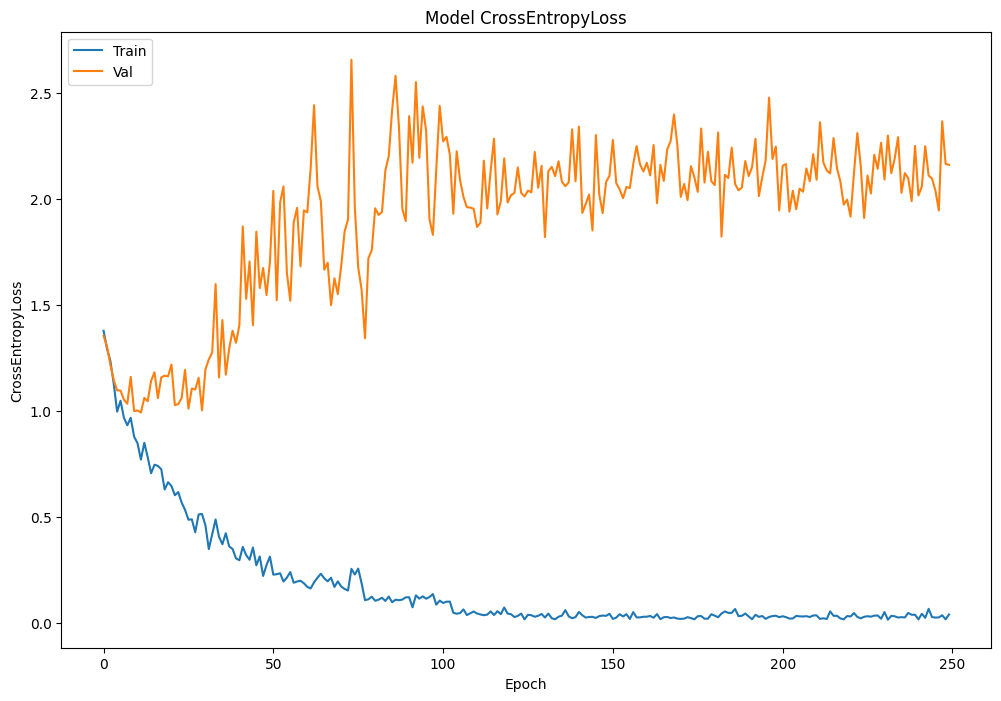

In [15]:

saved = save_logs(os.path.join(model_path, TRAIN_VAL_LOGS), metrics_lists)
print(f'save_logs(): {saved}')

train_val_plot_path = save_plots(model_path, metrics_lists)
print(f'train_val_plot_path: {train_val_plot_path}')


In [16]:

model.eval() # Set model to the evaluation mode
preds_dir = os.path.join(model_path, 'preds')
all_preds, all_labels, acc_file = save_predictions(test_loader, model, preds_dir)

print(f'acc_file: {acc_file}')

#print(f'len(regions_paths): {len(regions_paths)}')
#print(f'regions_paths: {regions_paths}')


accuracy: 0.6
acc_file: C:\Users\n.litvinenko\PycharmProjects\Procedia\models\ResNet\ResNet\epochs_250__batch_8__net_resnet101d__PRETRAINED_True__optimizer_Adam__lr_scheduler_ReduceLROnPlateau__LR1_0.0001___SIZE_333\preds\accuracy.txt


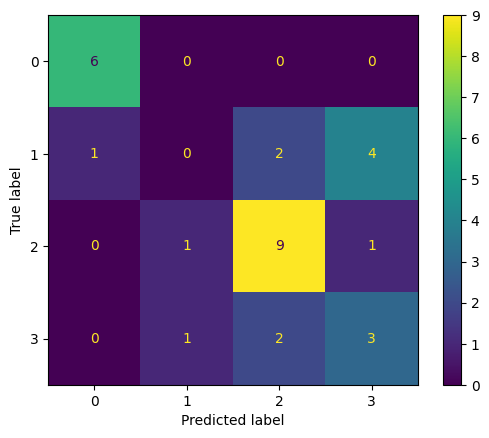

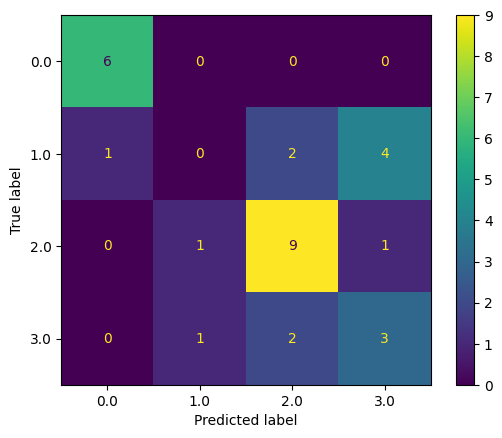

In [17]:

cm = confusion_matrix(all_labels, all_preds, labels = CLASSES)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = CLASSES)
disp.plot()
plt.show()

IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
cm = ConfusionMatrixDisplay.from_estimator(IC, all_preds, all_labels, normalize=None)
cm_path = os.path.join(model_path, 'confusion_matrix.png')
cm.figure_.savefig(cm_path)


In [19]:
dirs_files = []

for folder in os.listdir(CAPILLAROSCOPY_PATH):
    folder_path = os.path.join(CAPILLAROSCOPY_PATH, folder)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        dirs_files.append(len(os.listdir(folder_path)))

print(f'len(dirs_files): {len(dirs_files)}')
print(f'dirs_files: {dirs_files}')


len(dirs_files): 64
dirs_files: [2947, 2659, 2748, 2879, 2677, 2700, 2746, 2654, 2561, 2674, 2693, 2695, 2721, 2561, 2609, 2697, 2703, 2682, 2637, 2699, 2686, 2669, 2729, 2755, 2564, 2563, 2721, 2656, 2763, 3105, 2688, 2687, 2693, 515, 2590, 2774, 2556, 2696, 2683, 2765, 2685, 2666, 2699, 2674, 2720, 2663, 2653, 2588, 2587, 2739, 2748, 2693, 2563, 2662, 2663, 2734, 2737, 2791, 1445, 2785, 2689, 2741, 2690, 2605]


In [20]:
print(f'min(dirs_files): {min(dirs_files)}')
print(f'max(dirs_files): {max(dirs_files)}')

min(dirs_files): 515
max(dirs_files): 3105


In [21]:
print(f'avg(dirs_files) : {sum(dirs_files) / len(dirs_files)}')

avg(dirs_files) : 2640.9375
